In [31]:
import os
import scipy.io
import pandas as pd
import numpy 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf

from bibliotheque_ensta import *
print('ok')

ok


In [32]:
nom_dir = "/home/datawork-osmose/dataset/ml18_295b/analysis/getFeatures/32000/1H/"

os.chdir(nom_dir)
os.getcwd()

ll = nom_dir + "complete.pkl"

[total_welch, total_tol, aux, total_time, frequencies] = pickle.load(open(ll, 'rb'))

In [33]:
X = prepa_total_tol_time(total_tol, total_time)

In [34]:
nom_dir = "/home4/datahome/rbessoua/Guinet/ml18_295b/"

os.chdir(nom_dir)
os.getcwd()

target = pd.read_csv(nom_dir+"ml18_295b_y_final.csv")
target.head()

,year,month,day,hour,u10,v10,tp
0,2018,10,22,21,-2.773657,5.800243,1.304275e-07
1,2018,10,22,22,-2.294206,5.358380,-8.673617e-19
2,2018,10,22,23,-1.813718,4.787569,-8.673617e-19
3,2018,10,23,0,-1.408388,4.210645,4.304108e-06
4,2018,10,23,1,-0.957963,3.575918,1.434703e-06


In [35]:
data = target.merge(X, on = ['year', 'month', 'day', 'hour'])

data['w10']=data['u10']
for i in range(len(data)):
    data['w10'].loc[i] = root_mean_squarred(data['u10'].iloc[i], data['v10'].iloc[i])

/home4/datahome/rbessoua/conda-env/dl-env/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='w10', ylabel='Count'>

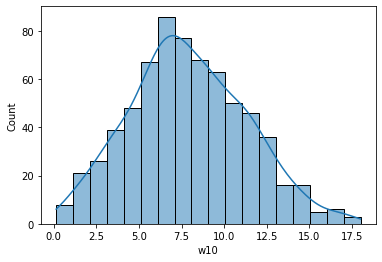

In [36]:
sns.histplot(data['w10'], kde=True)

In [37]:
X = data.drop(['u10', 'v10', 'w10', 'tp'], axis=1)
Y = data['w10']

## Random Forest Transfer (SPMAuralA)

In [9]:
!pip install joblib

from joblib import dump, load
import os
nom_dir = "/home4/datahome/rbessoua/modeles/"

os.chdir(nom_dir)

rf = load('rfv_SPMAuralA.joblib') 

  Retrying (Retry(total=4, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x2aaaad473908>: Failed to establish a new connection: [Errno 101] Network is unreachable',)': /simple/joblib/
  Retrying (Retry(total=3, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x2aaaad473e80>: Failed to establish a new connection: [Errno 101] Network is unreachable',)': /simple/joblib/
  Retrying (Retry(total=2, connect=None, read=None, redirect=None, status=None)) after connection broken by 'NewConnectionError('<pip._vendor.urllib3.connection.VerifiedHTTPSConnection object at 0x2aaaad473f60>: Failed to establish a new connection: [Errno 101] Network is unreachable',)': /simple/joblib/
  Retrying (Retry(total=1, connect=None, read=None, redirect=None, status=None)) a

<AxesSubplot:>

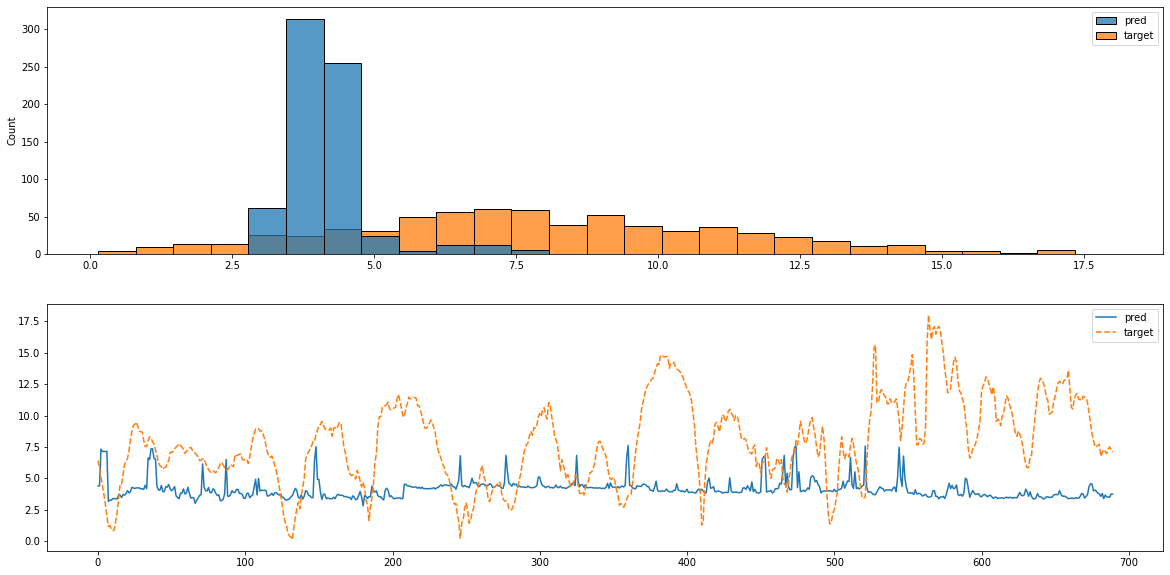

In [10]:
pred_rf = rf.predict(X)

histo = pd.DataFrame(data={'pred':pred_rf, 'target':data['w10']})
plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)

## Neural network (SPMAuralA)

In [13]:
from keras.models import load_model

nom_dir = "/home4/datahome/rbessoua/modeles/"

os.chdir(nom_dir)
os.getcwd()

model = load_model('nnv_spmaurala.h5')

<AxesSubplot:>

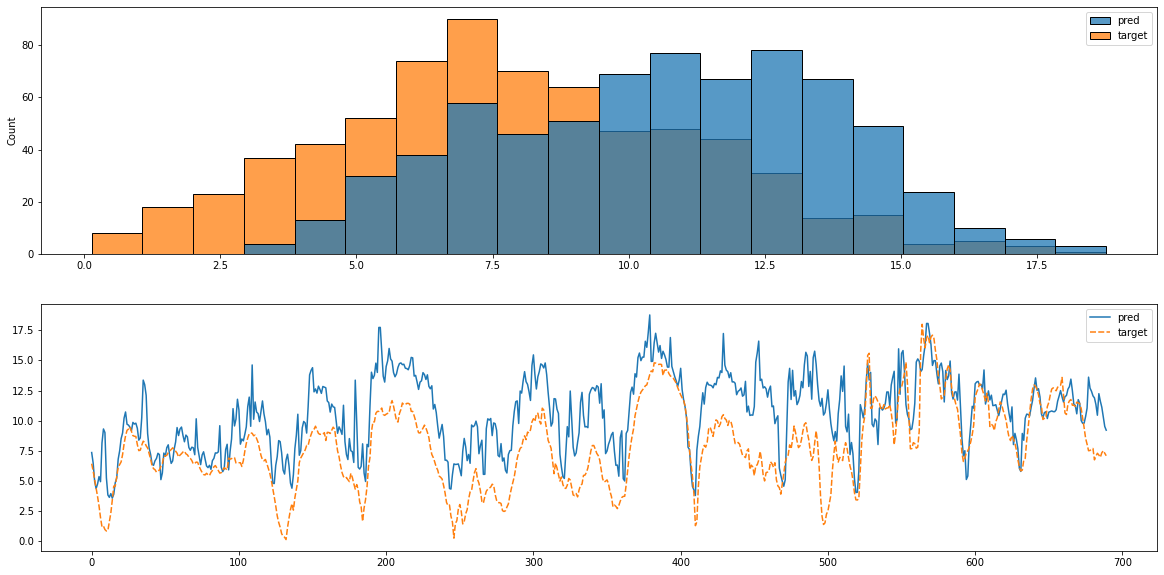

In [12]:
X_dl = X.values

min_max_scaler = MinMaxScaler()
X_dl = min_max_scaler.fit_transform(X_dl)

pred_nn = model.predict(X_dl).reshape(-1)

histo = pd.DataFrame(data={'pred':pred_nn, 'target':data['w10']})
plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)

In [13]:
print(f"The MSE is : {np.mean((data['w10'] - pred_nn)**2)}")

The MSE is : 13.039590699727405


## Amelioration

In [14]:
rf = load('rfclassiv_SPMAuralA.joblib') 
model_faible = load_model('nnvf_spmaurala.h5')
model_fort = load_model('nnvfort_spmaurala.h5')

<AxesSubplot:xlabel='w10', ylabel='Count'>

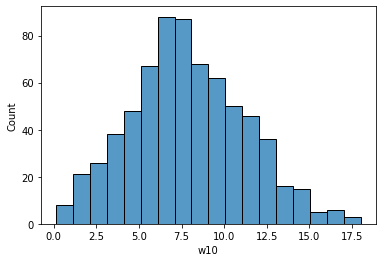

In [15]:
y_pred_classi = rf.predict(X)

Y_faible = data['w10'][(y_pred_classi == 0)]    
X_faible = X[(y_pred_classi == 0)]

Y_fort = data['w10'][(y_pred_classi == 1)]    
X_fort = X[(y_pred_classi == 1)]

idx_faible = np.where(y_pred_classi==0)
idx_fort = np.where(y_pred_classi==1)

sns.histplot(Y_faible)

In [16]:
pred_nn_faible = model_faible.predict(X_faible)
pred_nn_fort = model_fort.predict(X_fort)

ValueError: Expect x to be a non-empty array or dataset.

In [ ]:
res=[0 for i in range(len(X))]
for i, j in enumerate (idx_faible[0]):
    res[j] = pred_nn_faible[i]
for i, j in enumerate(idx_fort[0]):
    res[j] = pred_nn_fort[i]

histo = pd.DataFrame(data={'pred':res, 'target':data['w10']})

plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)
#plt.savefig(path+'70_amelioration_nn_pred_finale.png')

# Transfert modele de Poisson 

In [54]:
X = data.drop(['u10', 'v10', 'w10', 'tp'], axis=1)
Y = data['tp']

In [55]:
def NLL(y_true, y_hat): 
      return -y_hat.log_prob(y_true)

In [65]:
nom_dir = "/home4/datahome/rbessoua/modeles/"

os.chdir(nom_dir)
os.getcwd()

model= load_model("nn_poisson.h5",
                  custom_objects = {"exp": tf.exp,"NLL":NLL})

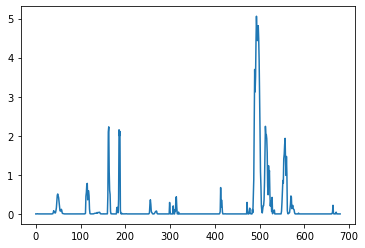

In [66]:
plt.plot(data['tp']*1000)

<AxesSubplot:>

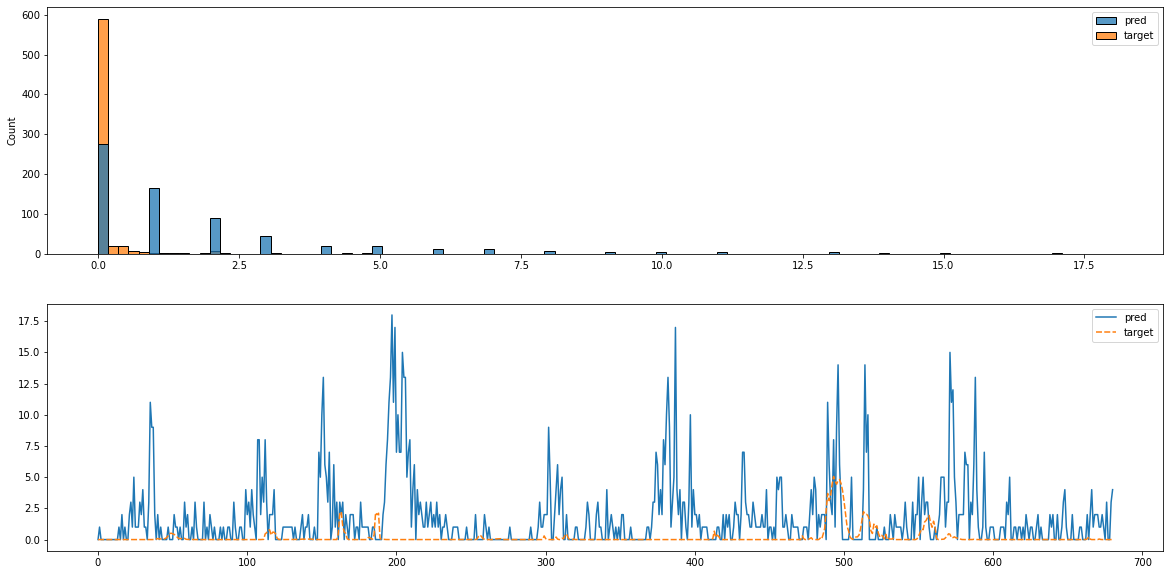

In [67]:
X_dl = X.values

min_max_scaler = MinMaxScaler()
X_dl = min_max_scaler.fit_transform(X_dl)

pred_nn = model.predict(X_dl).reshape(-1)

histo = pd.DataFrame(data={'pred':pred_nn, 'target':data['tp']*1000})
plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)

In [44]:
res = []
for i in pred_nn :
    if i > 1 :
        res.append(i)
    else : res.append(0)

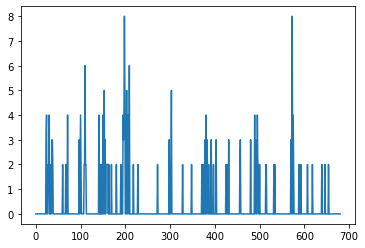

In [47]:
plt.plot(res)

In [51]:
histo = pd.DataFrame(data={'pred':np.array(res), 'target':data['tp']*1000})
plt.figure(1,figsize=(20,10))
plt.subplot(2,1,1)
sns.histplot(histo)
plt.subplot(2,1,2)
sns.lineplot(data = histo)

<AxesSubplot:>

Error in callback <function flush_figures at 0x2aaae4552940> (for post_execute):


KeyboardInterrupt: 